In [43]:
from Bio import SeqIO
from Bio.SubsMat.MatrixInfo import blosum62
import itertools
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import numpy as np
import re
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

In [3]:
#Convert DNA sequences to a numpy array
def string_to_array(seq_string):
    seq_string = seq_string.lower()
    seq_string = re.sub('[^acgt]', 'n', seq_string)
    seq_array = np.array(list(seq_string))
    return seq_array

In [4]:
#Initialize a label encoder for DNA characters
label_encoder = LabelEncoder()
label_encoder.fit(np.array(['a','c','g','t','z']))

LabelEncoder()

In [5]:
#Convert characters to ordinal encoding
def ordinal_encoder(dna_array):
    integer_encoded = label_encoder.transform(dna_array)
    float_encoded = integer_encoded.astype(float)
    float_encoded[float_encoded == 0] = 0.25
    float_encoded[float_encoded == 1] = 0.50 
    float_encoded[float_encoded == 2] = 0.75 
    float_encoded[float_encoded == 3] = 1.00 
    float_encoded[float_encoded == 4] = 0.00 
    return float_encoded

In [6]:
#Apply one hot encoding
def one_hot_encoder(seq_string):
    int_encoded = label_encoder.transform(seq_string)
    onehot_encoder = OneHotEncoder(sparse=False, dtype=int)
    int_encoded = int_encoded.reshape(len(int_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(int_encoded)
    onehot_encoded = np.delete(onehot_encoded, -1, 1)
    return onehot_encoded

In [7]:
#Generate k mers from a sequence
def Kmers_funct(seq, size):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]

In [8]:
mySeq1 = 'CTCACCTGTACAATCACACCCCATGTGC'
mySeq2 = 'GGTTCAGTGACCCAGGTGACCAGACAGG'

In [9]:
#Convert sequences to a space-separated string of k-mers
sentence1 = ' '.join(Kmers_funct(mySeq1, size=10))
sentence2 = ' '.join(Kmers_funct(mySeq2, size=10))

In [10]:
#Use CountVectorizer to convert text data into sparse matrix
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform([sentence1, sentence2]).toarray()

In [11]:
#Plot data distribution
def plot_dna_data(file_path, title_color):
    dna_data = pd.read_table(file_path)
    plt.figure()
    dna_data['class'].value_counts().sort_index().plot.bar(color=title_color)
    plt.title(f"{os.path.basename(file_path)} DNA", fontsize=16)
    plt.show()
    return dna_data

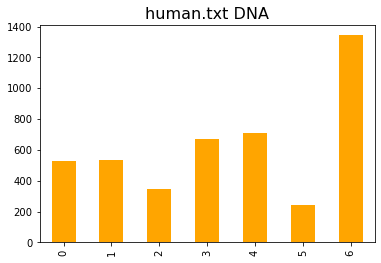

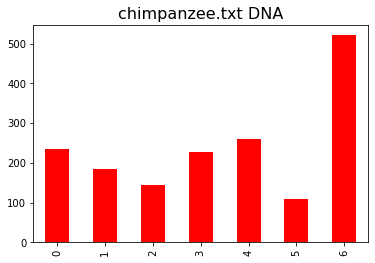

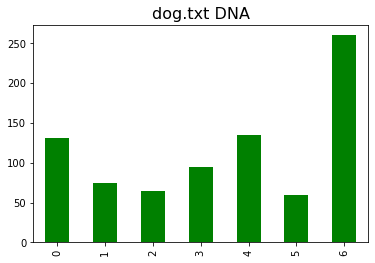

In [12]:
human_dna = plot_dna_data('../input/dna-sequence-dataset/human.txt', 'orange')
chimp_dna = plot_dna_data('../input/dna-sequence-dataset/chimpanzee.txt', 'red')
dog_dna = plot_dna_data('../input/dna-sequence-dataset/dog.txt', 'green')

In [13]:
#Extract features and target labels and apply Naive Bayes
def prepare_data_and_train(dna_data, species_name):
    texts = [' '.join(Kmers_funct(seq, size=6)) for seq in dna_data['sequence']]
    labels = dna_data['class'].values
    X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.20, random_state=42)
    cv = CountVectorizer(ngram_range=(4,4))
    X_train_cv = cv.fit_transform(X_train)
    X_test_cv = cv.transform(X_test)
    classifier = MultinomialNB(alpha=0.1)
    classifier.fit(X_train_cv, y_train)
    y_pred = classifier.predict(X_test_cv)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f"{species_name} - Accuracy: {accuracy:.3f}, Precision: {precision:.3f}")


In [14]:
#Apply training and evaluation for each species
prepare_data_and_train(human_dna, "Human")
prepare_data_and_train(chimp_dna, "Chimpanzee")
prepare_data_and_train(dog_dna, "Dog")


Human - Accuracy: 0.984, Precision: 0.984
Chimpanzee - Accuracy: 0.917, Precision: 0.925
Dog - Accuracy: 0.665, Precision: 0.771


In [15]:
def visualize_nucleotide_frequencies(sequences):
    nucleotide_counts = pd.Series(list(''.join(sequences).upper())).value_counts()
    nucleotide_counts = nucleotide_counts / nucleotide_counts.sum() * 100  # Convert to percentage
    plt.figure(figsize=(8, 5))
    sns.barplot(x=nucleotide_counts.index, y=nucleotide_counts.values, palette="viridis")
    plt.title('Nucleotide Frequencies')
    plt.xlabel('Nucleotide')
    plt.ylabel('Frequency (%)')
    plt.show()


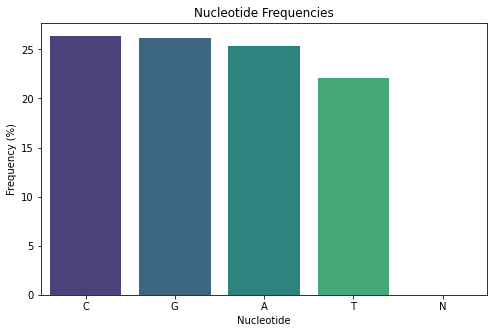

In [16]:
# Combine sequences from all datasets
all_sequences = human_dna['sequence'].tolist() + chimp_dna['sequence'].tolist() + dog_dna['sequence'].tolist()
visualize_nucleotide_frequencies(all_sequences)

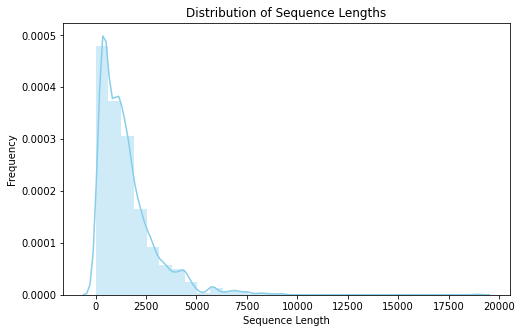

Mean Length: 1518.84
Median Length: 1161.00
Max Length: 18921
Min Length: 5


In [17]:
def analyze_sequence_lengths(sequences):
    lengths = [len(seq) for seq in sequences]
    plt.figure(figsize=(8, 5))
    sns.distplot(lengths, kde=True, bins=30, color="skyblue")  
    plt.title('Distribution of Sequence Lengths')
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.show()
    print(f"Mean Length: {np.mean(lengths):.2f}")
    print(f"Median Length: {np.median(lengths):.2f}")
    print(f"Max Length: {np.max(lengths)}")
    print(f"Min Length: {np.min(lengths)}")

analyze_sequence_lengths(all_sequences)

In [18]:
def inspect_unique_sequences(sequences):
    unique_seqs = len(set(sequences))
    print(f"Total Sequences: {len(sequences)}")
    print(f"Unique Sequences: {unique_seqs}")
    print(f"Percentage of Unique Sequences: {(unique_seqs / len(sequences)) * 100:.2f}%")

inspect_unique_sequences(all_sequences)


Total Sequences: 6882
Unique Sequences: 6061
Percentage of Unique Sequences: 88.07%


In [19]:
def check_non_standard_characters(sequences):
    all_chars = ''.join(sequences).upper()
    unique_chars = set(all_chars)
    standard_nucleotides = {'A', 'T', 'C', 'G', 'N'}
    non_standard_chars = unique_chars - standard_nucleotides
    print(f"Standard Nucleotides: {standard_nucleotides}")
    print(f"Unique Characters in Dataset: {unique_chars}")
    if non_standard_chars:
        print(f"Non-Standard Characters Found: {non_standard_chars}")
    else:
        print("No Non-Standard Characters Found.")

check_non_standard_characters(all_sequences)


Standard Nucleotides: {'T', 'N', 'C', 'G', 'A'}
Unique Characters in Dataset: {'T', 'N', 'C', 'G', 'A'}
No Non-Standard Characters Found.


In [20]:
def Kmers_funct(seq, size):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]


In [21]:
def prepare_data_and_train(dna_data, species_name, k_values=[4, 6, 8]):
    for k in k_values:
        print(f"\nTraining with K={k} for {species_name}...")
        texts = [' '.join(Kmers_funct(seq, size=k)) for seq in dna_data['sequence']]
        labels = dna_data['class'].values
        X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.20, random_state=42)
        
        cv = CountVectorizer()
        X_train_cv = cv.fit_transform(X_train)
        X_test_cv = cv.transform(X_test)
        
        classifier = MultinomialNB(alpha=0.1)
        classifier.fit(X_train_cv, y_train)
        y_pred = classifier.predict(X_test_cv)
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        print(f"K={k}, Accuracy: {accuracy:.3f}, Precision: {precision:.3f}")

In [22]:
def calculate_gc_content(sequence):
    gc_count = sequence.count('G') + sequence.count('C')
    return gc_count / len(sequence) * 100

In [23]:
def add_gc_content_feature(dna_data):
    dna_data['GC_Content'] = dna_data['sequence'].apply(calculate_gc_content)
    print(dna_data[['sequence', 'GC_Content']].head())

In [24]:
def prepare_data_and_train_with_gc(dna_data, species_name, k_values=[4, 6, 8]):
    add_gc_content_feature(dna_data)  
    for k in k_values:
        print(f"\nTraining with K={k} for {species_name} (including GC content)...")
        texts = [' '.join(Kmers_funct(seq, size=k)) for seq in dna_data['sequence']]
        labels = dna_data['class'].values
        gc_content = dna_data['GC_Content'].values
        
        combined_features = [text + f" GC_Content:{gc}" for text, gc in zip(texts, gc_content)]
        
        X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.20, random_state=42)
        
        cv = CountVectorizer()
        X_train_cv = cv.fit_transform(X_train)
        X_test_cv = cv.transform(X_test)
        
        classifier = MultinomialNB(alpha=0.1)
        classifier.fit(X_train_cv, y_train)
        y_pred = classifier.predict(X_test_cv)
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        print(f"K={k}, Accuracy: {accuracy:.3f}, Precision: {precision:.3f}")

In [25]:
def plot_gc_content_distribution(dna_data, species_name):
    if 'GC_Content' not in dna_data.columns:
        raise ValueError(f"GC_Content column missing in {species_name} dataset.")
    
    plt.figure(figsize=(8, 5))
    sns.distplot(dna_data['GC_Content'], kde=True, color='blue', bins=30)
    plt.title(f'GC Content Distribution for {species_name}')
    plt.xlabel('GC Content (%)')
    plt.ylabel('Frequency')
    plt.show()

In [26]:
# Recalculate and add GC content
if 'GC_Content' not in human_dna.columns:
    human_dna['GC_Content'] = human_dna['sequence'].apply(lambda seq: (seq.count('G') + seq.count('C')) / len(seq) * 100)

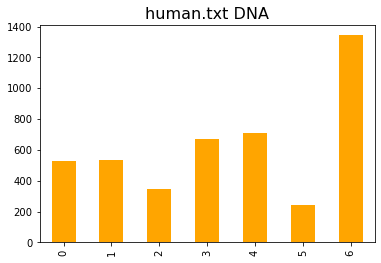

                                            sequence  GC_Content
0  ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...   39.613527
1  ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...   44.199706
2  ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...   43.119810
3  ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...   41.791045
4  ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...   42.727905

Training with K=4 for Human (including GC content)...
K=4, Accuracy: 0.352, Precision: 0.541

Training with K=6 for Human (including GC content)...
K=6, Accuracy: 0.622, Precision: 0.711

Training with K=8 for Human (including GC content)...
K=8, Accuracy: 0.957, Precision: 0.960


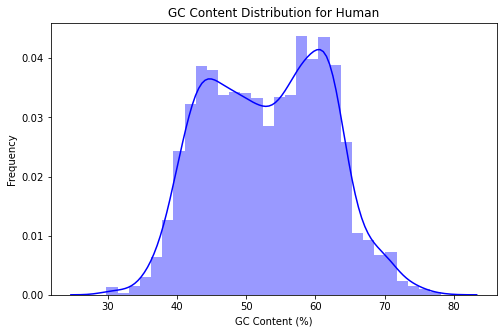

In [27]:
human_dna = plot_dna_data('../input/dna-sequence-dataset/human.txt', 'orange')

# Add GC content and train models with various K values
prepare_data_and_train_with_gc(human_dna, "Human", k_values=[4, 6, 8])
plot_gc_content_distribution(human_dna, "Human")

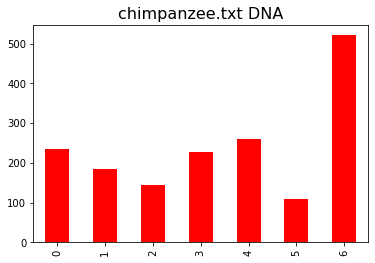

                                            sequence  GC_Content
0  ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...   40.096618
1  ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...   43.759178
2  ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...   47.516026
3  ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...   47.941889
4  ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...   63.789683

Training with K=4 for Chimpanzee (including GC content)...
K=4, Accuracy: 0.433, Precision: 0.625

Training with K=6 for Chimpanzee (including GC content)...
K=6, Accuracy: 0.632, Precision: 0.718

Training with K=8 for Chimpanzee (including GC content)...
K=8, Accuracy: 0.908, Precision: 0.923


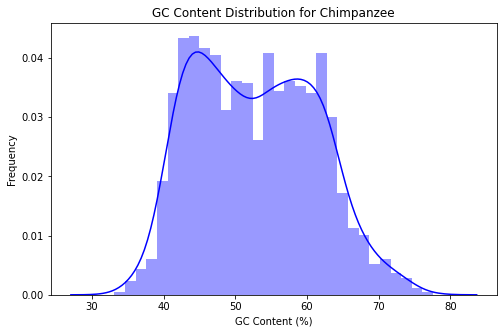

In [28]:
chimp_dna = plot_dna_data('../input/dna-sequence-dataset/chimpanzee.txt', 'red')

prepare_data_and_train_with_gc(chimp_dna, "Chimpanzee", k_values=[4, 6, 8])
plot_gc_content_distribution(chimp_dna, "Chimpanzee")

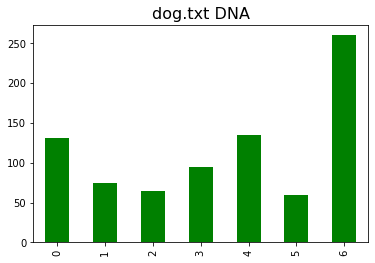

                                            sequence  GC_Content
0  ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...   35.294118
1  ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...   39.794420
2  ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...   71.455939
3  ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACGACTCATACG...   67.816092
4  ATGAGCCGGCAGCTAAACAGAAGCCAGAACTGCTCCTTCAGTGACG...   55.797101

Training with K=4 for Dog (including GC content)...
K=4, Accuracy: 0.427, Precision: 0.492

Training with K=6 for Dog (including GC content)...
K=6, Accuracy: 0.512, Precision: 0.578

Training with K=8 for Dog (including GC content)...
K=8, Accuracy: 0.640, Precision: 0.731


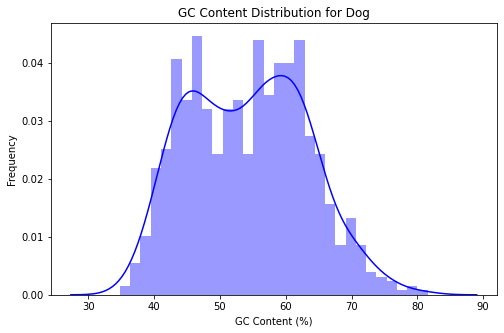

In [29]:
dog_dna = plot_dna_data('../input/dna-sequence-dataset/dog.txt', 'green')

prepare_data_and_train_with_gc(dog_dna, "Dog", k_values=[4, 6, 8])
plot_gc_content_distribution(dog_dna, "Dog")

In [30]:
def prepare_data_and_train_with_models(dna_data, species_name, k_values=[4, 6, 8]):
    for k in k_values:
        print(f"\nTraining with K={k} for {species_name}...")
        
        # Generate k-mers and split data
        texts = [' '.join(Kmers_funct(seq, size=k)) for seq in dna_data['sequence']]
        labels = dna_data['class'].values
        X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.20, random_state=42)
        
        # Vectorize k-mer data
        cv = CountVectorizer(ngram_range=(k, k))
        X_train_cv = cv.fit_transform(X_train)
        X_test_cv = cv.transform(X_test)
        
        # Train and evaluate Logistic Regression
        log_reg = LogisticRegression(max_iter=1000)
        log_reg.fit(X_train_cv, y_train)
        y_pred_log = log_reg.predict(X_test_cv)
        log_accuracy = accuracy_score(y_test, y_pred_log)
        log_precision = precision_score(y_test, y_pred_log, average='weighted')
        print(f"K={k}, Logistic Regression - Accuracy: {log_accuracy:.3f}, Precision: {log_precision:.3f}")
        
        # Train and evaluate SVM
        svm_model = SVC(kernel='linear', probability=True)
        svm_model.fit(X_train_cv, y_train)
        y_pred_svm = svm_model.predict(X_test_cv)
        svm_accuracy = accuracy_score(y_test, y_pred_svm)
        svm_precision = precision_score(y_test, y_pred_svm, average='weighted')
        print(f"K={k}, SVM - Accuracy: {svm_accuracy:.3f}, Precision: {svm_precision:.3f}")

In [31]:
def train_lstm(dna_data, species_name, k=6, max_length=100):
    print(f"\nTraining LSTM for {species_name} with K={k}...")
    
    # Generate k-mers
    texts = [' '.join(Kmers_funct(seq, size=k)) for seq in dna_data['sequence']]
    labels = dna_data['class'].values
    
    # Tokenize and pad sequences
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    X = tokenizer.texts_to_sequences(texts)
    X = pad_sequences(X, maxlen=max_length)
    
    # Encode labels
    y = pd.get_dummies(labels).values
    
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
    # LSTM model
    model = Sequential([
        Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length),
        LSTM(128, return_sequences=False),
        Dense(64, activation='relu'),
        Dense(y_train.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"LSTM Model - Accuracy: {accuracy:.3f}")

In [32]:
# Logistic Regression and SVM
prepare_data_and_train_with_models(human_dna, "Human")
prepare_data_and_train_with_models(chimp_dna, "Chimpanzee")
prepare_data_and_train_with_models(dog_dna, "Dog")


Training with K=4 for Human...
K=4, Logistic Regression - Accuracy: 0.932, Precision: 0.935
K=4, SVM - Accuracy: 0.897, Precision: 0.903

Training with K=6 for Human...
K=6, Logistic Regression - Accuracy: 0.935, Precision: 0.946
K=6, SVM - Accuracy: 0.884, Precision: 0.916

Training with K=8 for Human...
K=8, Logistic Regression - Accuracy: 0.928, Precision: 0.942
K=8, SVM - Accuracy: 0.866, Precision: 0.907

Training with K=4 for Chimpanzee...
K=4, Logistic Regression - Accuracy: 0.932, Precision: 0.936
K=4, SVM - Accuracy: 0.902, Precision: 0.910

Training with K=6 for Chimpanzee...
K=6, Logistic Regression - Accuracy: 0.881, Precision: 0.911
K=6, SVM - Accuracy: 0.861, Precision: 0.900

Training with K=8 for Chimpanzee...
K=8, Logistic Regression - Accuracy: 0.881, Precision: 0.911
K=8, SVM - Accuracy: 0.858, Precision: 0.899

Training with K=4 for Dog...
K=4, Logistic Regression - Accuracy: 0.762, Precision: 0.788
K=4, SVM - Accuracy: 0.744, Precision: 0.775

Training with K=6 fo

In [33]:
# LSTM
train_lstm(human_dna, "Human")
train_lstm(chimp_dna, "Chimpanzee")
train_lstm(dog_dna, "Dog")


Training LSTM for Human with K=6...
Epoch 1/10
110/110 [==============================] - 12s 110ms/step - loss: 1.7253 - accuracy: 0.3390 - val_loss: 1.4963 - val_accuracy: 0.4429
Epoch 2/10
110/110 [==============================] - 12s 105ms/step - loss: 1.1553 - accuracy: 0.5982 - val_loss: 1.2274 - val_accuracy: 0.5936
Epoch 3/10
110/110 [==============================] - 12s 107ms/step - loss: 0.6089 - accuracy: 0.8062 - val_loss: 1.1735 - val_accuracy: 0.6598
Epoch 4/10
110/110 [==============================] - 11s 105ms/step - loss: 0.2613 - accuracy: 0.9232 - val_loss: 1.4368 - val_accuracy: 0.6404
Epoch 5/10
110/110 [==============================] - 12s 106ms/step - loss: 0.1061 - accuracy: 0.9709 - val_loss: 1.5831 - val_accuracy: 0.6861
Epoch 6/10
110/110 [==============================] - 12s 105ms/step - loss: 0.0483 - accuracy: 0.9872 - val_loss: 1.8054 - val_accuracy: 0.6849
Epoch 7/10
110/110 [==============================] - 11s 104ms/step - loss: 0.0213 - accurac

In [34]:
results = {
    "Human": {
        4: {"Logistic Regression": 0.932, "SVM": 0.897, "LSTM": 0.671},
        6: {"Logistic Regression": 0.935, "SVM": 0.884, "LSTM": 0.671},
        8: {"Logistic Regression": 0.928, "SVM": 0.866, "LSTM": 0.671},
    },
    "Chimpanzee": {
        4: {"Logistic Regression": 0.932, "SVM": 0.902, "LSTM": 0.677},
        6: {"Logistic Regression": 0.881, "SVM": 0.861, "LSTM": 0.677},
        8: {"Logistic Regression": 0.881, "SVM": 0.858, "LSTM": 0.677},
    },
    "Dog": {
        4: {"Logistic Regression": 0.762, "SVM": 0.744, "LSTM": 0.402},
        6: {"Logistic Regression": 0.543, "SVM": 0.543, "LSTM": 0.402},
        8: {"Logistic Regression": 0.543, "SVM": 0.543, "LSTM": 0.402},
    }
}

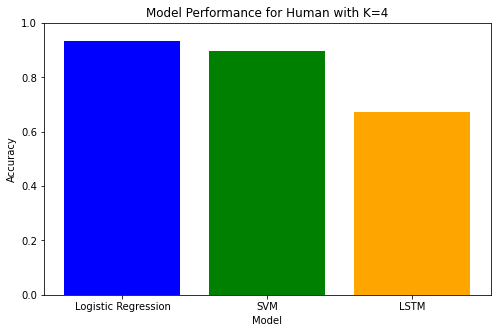

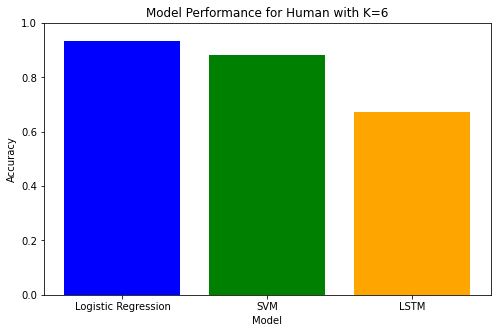

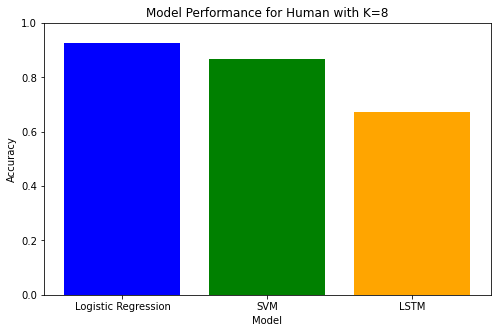

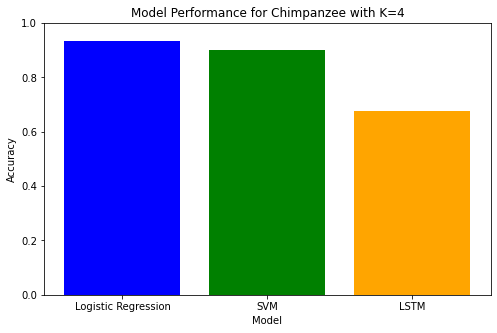

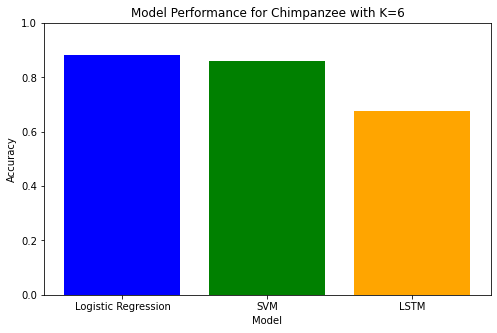

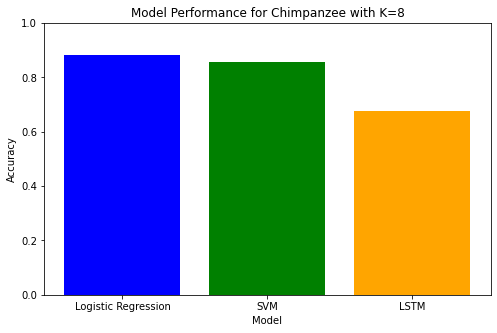

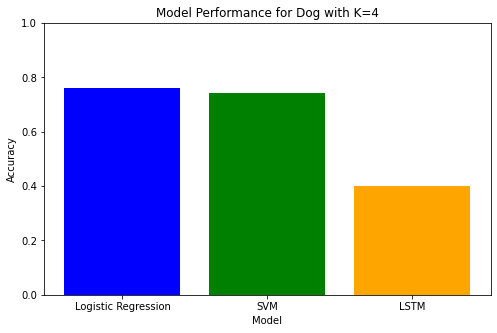

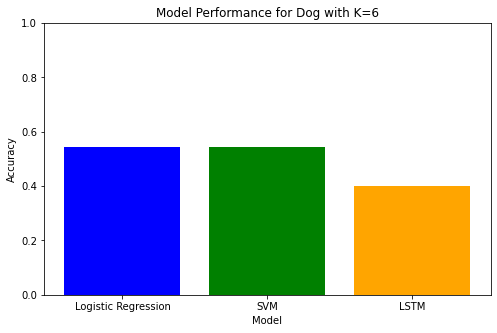

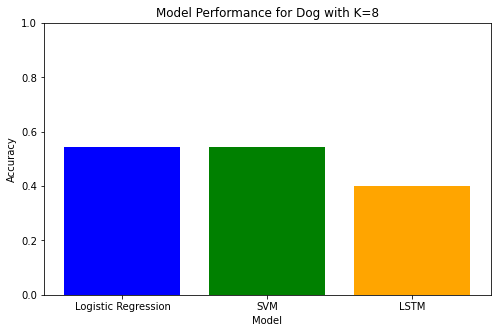

In [35]:
for species, k_values in results.items():
    for k, model_scores in k_values.items():
        models = list(model_scores.keys())
        scores = list(model_scores.values())
        
        plt.figure(figsize=(8, 5))
        plt.bar(models, scores, color=['blue', 'green', 'orange'])
        plt.title(f"Model Performance for {species} with K={k}")
        plt.xlabel("Model")
        plt.ylabel("Accuracy")
        plt.ylim(0, 1) 
        plt.show()


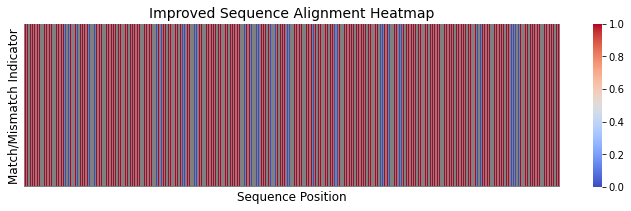

ATGCCCCAACTAAATACTAC-C-GTATGG-CCCACCATAATTACCCCCATACTCCTT-ACACTATTC-CTCA-TCACCCAACTAAAAATATTAAACA--CAAACT-ACCAC-CTACCTCCC-TCACCAAAG-CCCATAAAAATAAAAAAT-TAT-AAC-AAACCCTGAGAACCAAAATGAACGAAAATCTG-TTCGCTTCATTCAT--TGCCCCCACAATCCTAG
|||||||||||||||||  | | |||| | ||||||||||||||||||||||||| | ||||||||  |||  ||||||||||||||||||| || |  |||| | ||||  ||||| ||| ||||||||  |||||||||||||||||  ||  ||  |||||||||||||||||||||||||||||||  ||||||||||||    |||||||||||||||||
ATGCCCCAACTAAATAC--CGCCGTAT-GACCCACCATAATTACCCCCATACTCC-TGACACTATT-TCTC-GTCACCCAACTAAAAATATT-AA-ATTCAAA-TTACCA-TCTACC-CCCCTCACCAAA-ACCCATAAAAATAAAAAA-CTA-CAA-TAAACCCTGAGAACCAAAATGAACGAAAATCT-ATTCGCTTCATTC--GCTGCCCCCACAATCCTAG
  Score=189



In [36]:
def improved_sequence_alignment_heatmap(seq1, seq2):
    # global alignment
    alignments = pairwise2.align.globalxx(seq1, seq2)
    alignment = alignments[0]
    
    aligned_seq1 = alignment[0]
    aligned_seq2 = alignment[1]
    
    # Create a matrix with values 1 for matches and 0 for mismatches
    alignment_matrix = np.array([[1 if s1 == s2 else 0 for s1, s2 in zip(aligned_seq1, aligned_seq2)]])
    
    plt.figure(figsize=(12, 3))
    sns.heatmap(alignment_matrix, cbar=True, cmap="coolwarm", xticklabels=False, yticklabels=False, 
                linewidths=0.5, linecolor='gray')
    
    plt.title('Improved Sequence Alignment Heatmap', fontsize=14)
    plt.xlabel('Sequence Position', fontsize=12)
    plt.ylabel('Match/Mismatch Indicator', fontsize=12)
    plt.show()
    
    print(format_alignment(*alignment))

improved_sequence_alignment_heatmap(human_dna['sequence'].iloc[0], chimp_dna['sequence'].iloc[0])

In [37]:
def align_and_advanced_visualize(seq1, seq2, seq3, window_size=10, similarity_threshold=0.8, scoring_matrix=None):
    # Perform pairwise alignment for all species pairs
    alignments_12 = pairwise2.align.globalds(seq1, seq2, scoring_matrix, -10, -1) if scoring_matrix else pairwise2.align.globalxx(seq1, seq2)
    alignments_13 = pairwise2.align.globalds(seq1, seq3, scoring_matrix, -10, -1) if scoring_matrix else pairwise2.align.globalxx(seq1, seq3)
    alignments_23 = pairwise2.align.globalds(seq2, seq3, scoring_matrix, -10, -1) if scoring_matrix else pairwise2.align.globalxx(seq2, seq3)
    
    aligned_12 = alignments_12[0]
    aligned_13 = alignments_13[0]
    aligned_23 = alignments_23[0]
    
    def compute_similarity(aligned_seq1, aligned_seq2):
        similarity_scores = []
        for i in range(len(aligned_seq1) - window_size + 1):
            window_seq1 = aligned_seq1[i:i + window_size]
            window_seq2 = aligned_seq2[i:i + window_size]
            matches = sum(1 for a, b in zip(window_seq1, window_seq2) if a == b)
            similarity_scores.append(matches / window_size)
        return np.array(similarity_scores)
    
    # Compute similarity scores for all pairs
    similarity_12 = compute_similarity(aligned_12[0], aligned_12[1])
    similarity_13 = compute_similarity(aligned_13[0], aligned_13[1])
    similarity_23 = compute_similarity(aligned_23[0], aligned_23[1])
    
    return similarity_12, similarity_13, similarity_23

def plot_advanced_heatmap_all(similarity_12, similarity_13, similarity_23):
    plt.figure(figsize=(14, 6))
    
    plt.subplot(3, 1, 1)
    sns.heatmap(
        [similarity_12], cmap='coolwarm', cbar=True, xticklabels=False, yticklabels=False
    )
    plt.title('Human vs. Chimpanzee Similarity')
    
    plt.subplot(3, 1, 2)
    sns.heatmap(
        [similarity_13], cmap='coolwarm', cbar=True, xticklabels=False, yticklabels=False
    )
    plt.title('Human vs. Dog Similarity')
    
    plt.subplot(3, 1, 3)
    sns.heatmap(
        [similarity_23], cmap='coolwarm', cbar=True, xticklabels=False, yticklabels=False
    )
    plt.title('Chimpanzee vs. Dog Similarity')
    
    plt.tight_layout()
    plt.show()


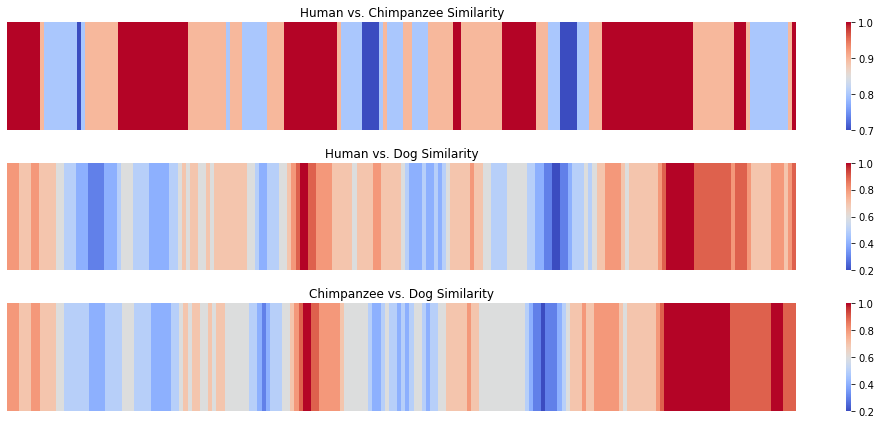

In [40]:
# Select sequences for comparison
seq1_human = human_dna['sequence'].iloc[0][:200]
seq2_chimp = chimp_dna['sequence'].iloc[0][:200]
seq3_dog = dog_dna['sequence'].iloc[0][:200]

# Use BLOSUM62 scoring matrix for comparison
similarity_12, similarity_13, similarity_23 = align_and_advanced_visualize(
    seq1_human, seq2_chimp, seq3_dog, window_size=10, scoring_matrix=blosum62
)

plot_advanced_heatmap_all(similarity_12, similarity_13, similarity_23)
